In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyiron import Project
plt.style.use('default')

In [2]:
pr = Project('Decohesion')

In [3]:
def model(el='Al', strain=None, ds=0, vac=False, repeat=(2,2,6)):
    structure = pr.create_ase_bulk(el, cubic=True).repeat(repeat)
    
    if not vac:
        a3_0 = structure.cell[2, 2]
        if strain is None:
            strain = ds/a3_0

        return structure.apply_strain([0, 0, strain], return_box=True)
    else:
        structure.cell[2, 2] += ds
        return structure

In [4]:
model(ds=10, vac=True).plot3d(view_plane=[0,1,0])

NGLWidget()

In [5]:
job = pr.create_job(pr.job_type.Lammps, "test")
job.structure = model()
potential = 'Al_H_Ni_Angelo_eam'
job.potential = potential

Create an array of elongation we will investigate.

In [6]:
ds_list = np.linspace(-1, 6, 51)

An "interactive job" keeps the same Lammps instance runnning, while we feed it new structures on the fly.  We use it here to supply the strained structures on after the others.

In [7]:
job = pr.create_job(pr.job_type.Lammps, "strain",True)
job.structure = model()
job.potential = potential
job.interactive_open()
job.interactive_enforce_structure_reset=True
for ds in ds_list:
    job.structure = model(ds=ds)
    job.run()
    
job.interactive_close()

This group does not exist in the HDF5 file strain
The job strain was saved and received the ID: 1


`job.output` collects all the output from lammps for each of the structures that we gave during the interactive run.

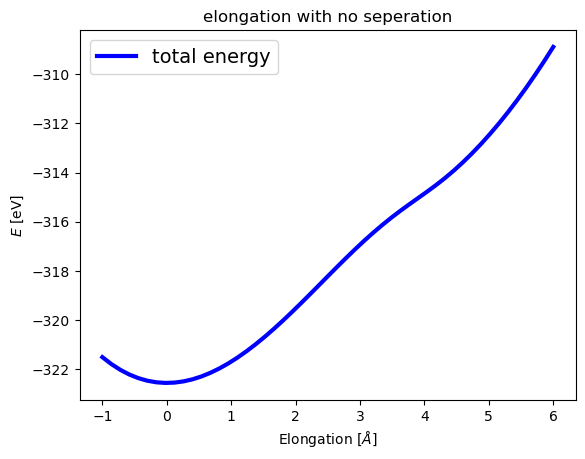

In [8]:
plt.plot(ds_list,job.output.energy_tot,'b', linewidth = 3,label='total energy')
plt.title('elongation with no seperation')
plt.xlabel('Elongation [$\AA$]')
plt.ylabel('$E$ [eV]')
plt.legend(loc = 'best', fontsize = 14)

Now repeat the same calculations, but introduce a "vaccum" separation between one crystal plane, instead of elastically stretching it.  We just perform a static energy calculation here, so this corresponds to the "rigid" work of separation as in Rebecca's talk.

In [9]:
job = pr.create_job(pr.job_type.Lammps, "vac", True)
job.structure = model()
job.potential = potential
job.interactive_open()
job.calc_static()
job.interactive_enforce_structure_reset=True
for ds in ds_list:
    job.structure = model(ds=ds, vac=True)
    job.run()
    
job.interactive_close()

This group does not exist in the HDF5 file vac
The job vac was saved and received the ID: 2


In the decohesion zone model, we assume that crack formation is governed by a simple energy balance between the energy stored in the strain field versus the energy of the two surface energy.  Once two surfaces are more favorable  crack should form.  Below we plot both energies to find that point.

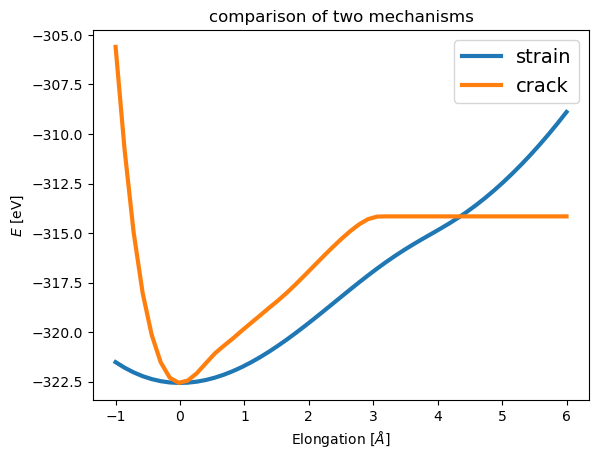

In [10]:
strain = pr.load('strain')
vac = pr.load('vac')
plt.plot(ds_list, strain['output/generic/energy_tot'], label=strain.name, linewidth = 3)
plt.plot(ds_list, vac['output/generic/energy_tot'], label="crack", linewidth = 3)
    
plt.legend()
plt.title('comparison of two mechanisms')
plt.xlabel('Elongation [$\AA$]')
plt.ylabel('$E$ [eV]')
plt.legend(loc = 'best', fontsize = 14)

## Size Convergence

The argumentation above has one problem, that the strain energy goes with the volume of the sample, but the crack formation energy only on the surface area.  Hence as the total volume increases the energy barrier per atom will decrease.  We will repeat both caluclations, but with half the system size in the strain direction.

In [11]:
n_layer = 3

In [12]:
job = pr.create_job(pr.job_type.Lammps, f"strain_l{n_layer}",True)
job.structure = model()
job.potential = potential
job.interactive_open()
job.interactive_enforce_structure_reset=True
for ds in ds_list:
    job.structure = model(ds=ds, repeat = [2, 2, n_layer])
    job.run()
    
job.interactive_close()

This group does not exist in the HDF5 file strain_l3
The job strain_l3 was saved and received the ID: 3


In [13]:
job = pr.create_job(pr.job_type.Lammps, f"vac_l{n_layer}", True)
job.structure = model()
job.potential = potential
job.interactive_open()
job.interactive_enforce_structure_reset=True
for ds in ds_list:
    job.structure = model(ds=ds, vac=True, repeat=[2, 2, n_layer])
    job.run()
    
job.interactive_close()

This group does not exist in the HDF5 file vac_l3
The job vac_l3 was saved and received the ID: 4


The system sizes are stored for each caluclation step and we can use to normalize the separation to strains.  Similarly the atomic structure is saved and we can use its length to normalize to energy per atom.

In [14]:
job['output/generic/cells'][:, 2,2]

array([11.15, 11.29, 11.43, 11.57, 11.71, 11.85, 11.99, 12.13, 12.27,
       12.41, 12.55, 12.69, 12.83, 12.97, 13.11, 13.25, 13.39, 13.53,
       13.67, 13.81, 13.95, 14.09, 14.23, 14.37, 14.51, 14.65, 14.79,
       14.93, 15.07, 15.21, 15.35, 15.49, 15.63, 15.77, 15.91, 16.05,
       16.19, 16.33, 16.47, 16.61, 16.75, 16.89, 17.03, 17.17, 17.31,
       17.45, 17.59, 17.73, 17.87, 18.01, 18.15])

Text(0, 0.5, '$E$ [eV/atom]')

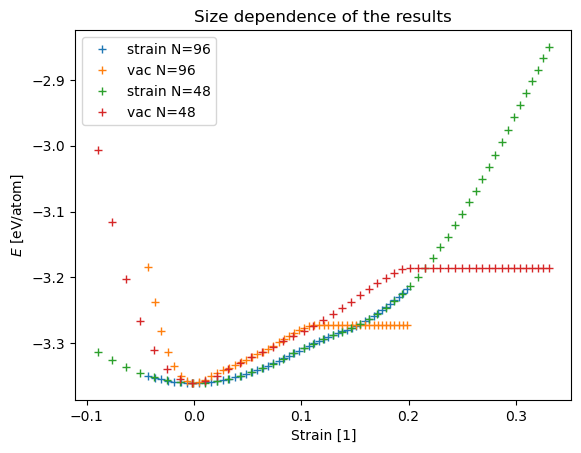

In [15]:
label_mat=['strain_l6','vac_l6','strain_l3','vac_l3'];
i=0
jobs = [
    pr.load('strain'),
    pr.load('vac'),
    pr.load('strain_l3'),
    pr.load('vac_l3'),
]
for job in jobs:
    L =job['output/generic/cells'][:, 2,2]
    N = job['output/generic/positions'].shape[1]
    plt.plot(ds_list / L, job['output/generic/energy_tot'] / N, '+',
             label="{} N={}".format(job.name.split('_')[0],  N), linewidth = 2)

plt.legend()
plt.title('Size dependence of the results')
plt.xlabel('Strain [1]')
plt.ylabel('$E$ [eV/atom]')

We can also look at the stress-strain curves  to see different maximum stresses the two mechanism support.  Unsurprisingly the crack mode supports a much lower stress.

Text(0, 0.5, '$\\sigma$ [GPa]')

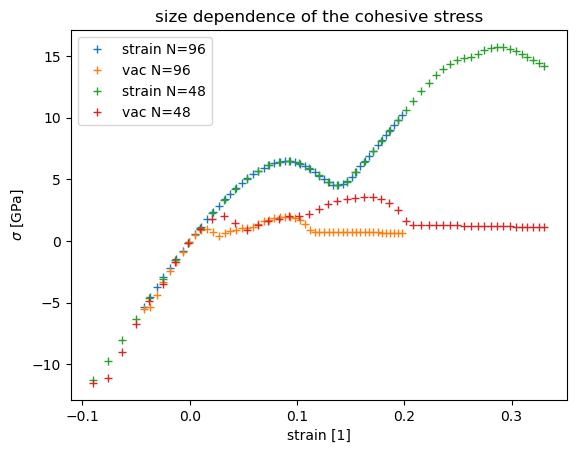

In [16]:
for job in jobs:
    L =job['output/generic/cells'][:, 2,2]
    N = job['output/generic/positions'].shape[1]
    plt.plot(ds_list / L, -job['output/generic/pressures'][:, 2, 2], '+',
             label="{} N={}".format(job.name.split('_')[0],  N), linewidth = 2)

plt.legend()
plt.title('size dependence of the cohesive stress')
plt.xlabel('strain [1]')
plt.ylabel('$\sigma$ [GPa]')

We want to see now the effect of adding hydrogen to our structure.  We modify our `model()` to support this by copying the original structure, shifting the positions by (fractional coordinates) 1/4,1/4,1/4 and then adding hydrogen to a random subset of this new lattice.  The shift ensures that we place hydrogen on the tetrahydral interstitials.

In [17]:
def model(el='Al', strain=None, ds=0, vac=False, n_H=0, repeat=(2,2,6), solute='H'):
    structure = pr.create_ase_bulk(el, cubic=True).repeat(repeat)
    if n_H > 0:
        h_structure = structure.copy()
        h_structure[:] = solute
        pos = h_structure.get_scaled_positions()
        h_structure.set_scaled_positions(pos + 1/4/np.array(repeat))
        structure += h_structure[np.random.choice(len(structure), replace=False, size=n_H)]
    
    if not vac:
        a3_0 = structure.cell[2, 2]
        if strain is None:
            strain = ds/a3_0

        return structure.apply_strain([0, 0, strain], return_box=True)
    else:
        structure.cell[2, 2] += ds
        return structure

In [18]:
model(n_H=10).plot3d()

NGLWidget()

We now repeat the calculations in Nickel, just strain, strain with additional hydrogen and the vacuum with no hydrogen.

In [19]:
n_H = 5
job = pr.create_job(pr.job_type.Lammps, f"ni_strain_l{n_layer}", True)
job.structure = model(el='Ni', n_H=0, repeat=[4,4,n_layer])
job.potential = potential
job.interactive_open()
job.calc_minimize(n_print=1)
job.interactive_enforce_structure_reset=True
for ds in ds_list:
    job.structure = model(el='Ni', n_H=0, ds=ds, repeat=[4, 4, n_layer])
    job.run()
    
job.interactive_close()

This group does not exist in the HDF5 file ni_strain_l3
The job ni_strain_l3 was saved and received the ID: 5


In [20]:
job.animate_structure()

NGLWidget(max_frame=50)

Text(0, 0.5, 'E [eV/atom]')

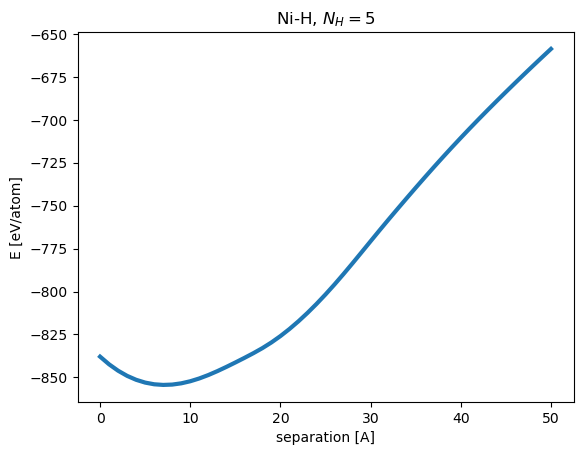

In [21]:
plt.plot(job.output.energy_tot,linewidth=3)
plt.title('Ni-H, $N_H=5$')
plt.xlabel('separation [A]')
plt.ylabel('E [eV/atom]')

In [22]:
n_H = 5
job = pr.create_job(pr.job_type.Lammps, f"ni_strain_h{n_H}_l{n_layer}", True)
job.structure = model(el='Ni', n_H=n_H, repeat=[4,4,n_layer])
job.potential = potential
job.interactive_open()
job.calc_minimize(n_print=1)
job.interactive_enforce_structure_reset=True
for ds in ds_list:
    job.structure = model(el='Ni', n_H=n_H, ds=ds, repeat=[4, 4, n_layer])
    job.run()
    
job.interactive_close()

This group does not exist in the HDF5 file ni_strain_h5_l3
The job ni_strain_h5_l3 was saved and received the ID: 6


In [23]:
pr['ni_strain_h5_l3'].animate_structure()

NGLWidget(max_frame=50)

Text(0, 0.5, 'E [eV/atom]')

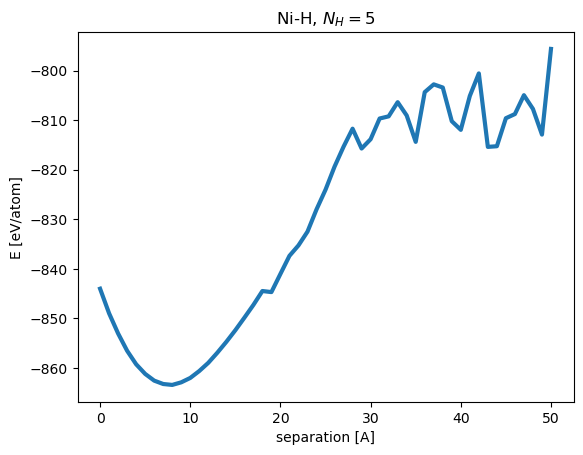

In [24]:
plt.plot(job.output.energy_tot,linewidth=3)
plt.title('Ni-H, $N_H=5$')
plt.xlabel('separation [A]')
plt.ylabel('E [eV/atom]')

In [25]:
job = pr.create_job(pr.job_type.Lammps, f"ni_vac_l{n_layer}", True)
job.structure = model(el='Ni', repeat=[4, 4, n_layer])
job.potential = potential
job.interactive_open()
job.interactive_enforce_structure_reset=True
for ds in ds_list:
    job.structure = model(el='Ni', ds=ds, vac=True, repeat=[4, 4, n_layer])
    job.run()
    
job.interactive_close()

This group does not exist in the HDF5 file ni_vac_l3
The job ni_vac_l3 was saved and received the ID: 7


Text(0, 0.5, 'E [eV]')

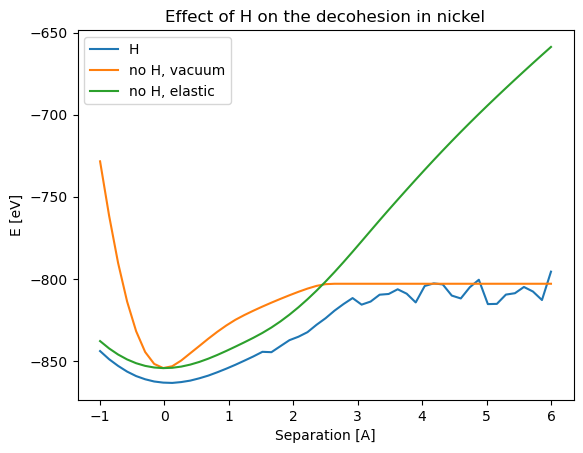

In [26]:
plt.plot(ds_list, pr.load('ni_strain_h5_l3').output.energy_tot, label='H')
plt.plot(ds_list, pr.load('ni_vac_l3').output.energy_tot, label='no H, vacuum')
plt.plot(ds_list, pr.load('ni_strain_l3').output.energy_tot, label='no H, elastic')
plt.legend()
plt.legend()
plt.title('Effect of H on the decohesion in nickel')
plt.xlabel('Separation [A]')
plt.ylabel('E [eV]')

(0.0, 40.48965886381531)

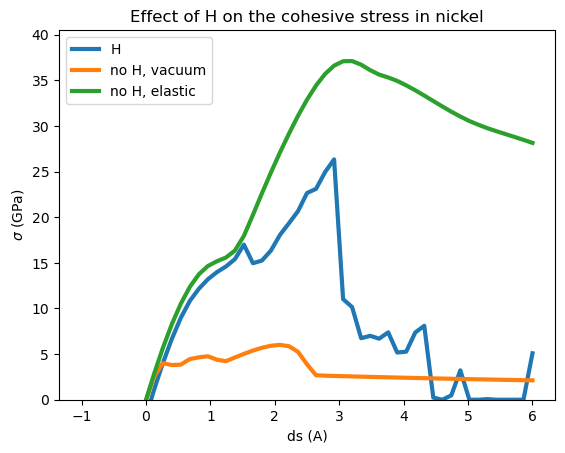

In [27]:
plt.plot(ds_list, -pr.load('ni_strain_h5_l3').output.pressures[:, 2,2], label='H',linewidth=3)
plt.plot(ds_list, -pr.load('ni_vac_l3').output.pressures[:, 2,2], label = 'no H, vacuum',linewidth=3)
plt.plot(ds_list, -pr.load('ni_strain_l3').output.pressures[:, 2,2], label = 'no H, elastic',linewidth=3)
plt.title('Effect of H on the cohesive stress in nickel')
plt.xlabel('ds (A)')
plt.ylabel('$\sigma$ (GPa)')
plt.legend()
plt.ylim(0, None)

Here we just add another set of calculations with a aluminum solute, to see if the effect is hydrogen specific.

In [28]:
n_H = 5
job = pr.create_job(pr.job_type.Lammps, f"ni_vac_al{n_H}_l{n_layer}", True)
job.structure = model(el='Ni', n_H=n_H, repeat=[4,4,n_layer], solute='Al')
job.potential = potential
job.interactive_open()
job.calc_minimize(n_print=1)
job.interactive_enforce_structure_reset=True
for ds in ds_list:
    job.structure = model(el='Ni', n_H=n_H, ds=ds, vac=True, repeat=[4, 4, n_layer], solute='Al')
    job.run()
    
job.interactive_close()

This group does not exist in the HDF5 file ni_vac_al5_l3
The job ni_vac_al5_l3 was saved and received the ID: 8


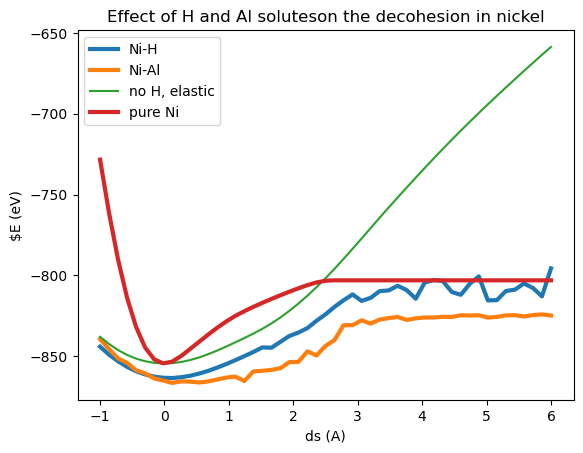

In [32]:
plt.plot(ds_list, pr.load('ni_strain_h5_l3').output.energy_tot, label='Ni-H',linewidth=3)
plt.plot(ds_list, pr.load('ni_vac_al5_l3').output.energy_tot, label='Ni-Al',linewidth=3)
plt.plot(ds_list, pr.load('ni_strain_l3').output.energy_tot, label='no H, elastic')
plt.plot(ds_list, pr.load('ni_vac_l3').output.energy_tot, label='pure Ni',linewidth=3)
plt.title('Effect of H and Al soluteson the decohesion in nickel')
plt.xlabel('ds (A)')
plt.ylabel('$E (eV)')
plt.legend()

(0.0, 40.687819740776945)

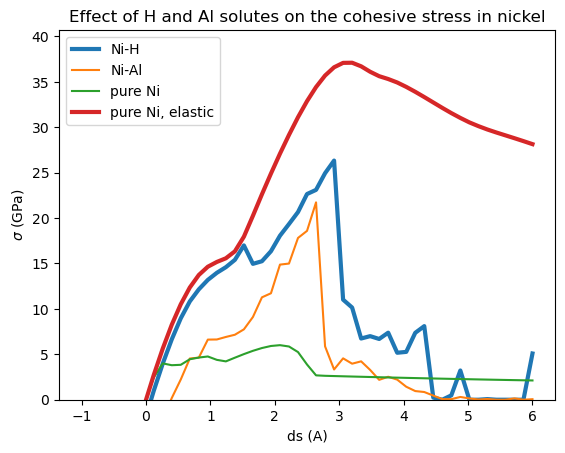

In [33]:
plt.plot(ds_list, -pr.load('ni_strain_h5_l3').output.pressures[:, 2,2], label='Ni-H',linewidth=3)
plt.plot(ds_list, -pr.load('ni_vac_al5_l3').output.pressures[:, 2,2], label='Ni-Al')
plt.plot(ds_list, -pr.load('ni_vac_l3').output.pressures[:, 2,2], label = 'pure Ni')
plt.plot(ds_list, -pr.load('ni_strain_l3').output.pressures[:, 2,2], label = 'pure Ni, elastic',linewidth=3)
plt.legend()
plt.title('Effect of H and Al solutes on the cohesive stress in nickel')
plt.xlabel('ds (A)')
plt.ylabel('$\sigma$ (GPa)')
plt.legend()
plt.ylim(0, None)